Following the tutorial outlined here:
https://machinelearningmastery.com/modeling-pipeline-optimization-with-scikit-learn/

In [3]:
from pandas import read_csv, DataFrame, unique
from numpy import ravel
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier # may need a different model here
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV

In [4]:
#use the tutorial dataset for now

ecoli_data = read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/ecoli/ecoli.data", sep = "\s+", header=None)
ecoli_data.head()


,0,1,2,3,4,5,6,7,8
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


In [5]:
ecoli_data.iloc[:,8].unique()

array(['cp', 'im', 'imS', 'imL', 'imU', 'om', 'omL', 'pp'], dtype=object)

The last label is the class label - separate into features and class label datasets. 2/3 training and 1/3 test.

In [6]:
# feature set
X = ecoli_data.iloc[:,1:-1]
# the labels
y = (ecoli_data.iloc[:,-1:])

# encode the labels to unique  numbers
encoder = LabelEncoder()
y = encoder.fit_transform(ravel(y))

In [8]:
# split data into test and train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=0)

print(X_train.shape)
print(X_test.shape)

(224, 7)
(112, 7)


Set up a basic pipeline with:
1) Scaling(preprocessing)
2) Feature selector
3) Classifier

In [9]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("selector", VarianceThreshold()),
    ("classifier", KNeighborsClassifier())
])

Simple pipeline with a scaler, selector and classifier. Call fit() on the training data to get the training and test scores

In [10]:
pipe.fit(X_train, y_train)

print('Training set score: ' + str(pipe.score(X_train, y_train)))
print('Test set score: ' + str(pipe.score(X_test, y_test)))

Training set score: 0.8794642857142857
Test set score: 0.8392857142857143


You can add parameters as a variable with key:value pair to search for the best scaler, selection threshold and classifier hyperparameters.

In [27]:
parameters = {'scaler': [StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler()],
'selector__threshold': [0, 0.001, 0.01],
'classifier__n_neighbors': [1, 3, 5, 7, 10],
'classifier__p': [1, 2],
'classifier__leaf_size': [1, 5, 10, 15]
}

The pipe and the ahove parameters dictionary are then passed to GridSearchCV() object to search the parameters space for the best parameters as shown below:

In [29]:
grid = GridSearchCV(pipe, parameters, cv=2, scoring="accuracy")
grid.fit(X_train, y_train)

/Users/annebraae/opt/anaconda3/envs/ml_env_3-9/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selector', VarianceThreshold()),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__leaf_size': [1, 5, 10, 15],
                         'classifier__n_neighbors': [1, 3, 5, 7, 10],
                         'classifier__p': [1, 2],
                         'scaler': [StandardScaler(), MinMaxScaler(),
                                    Normalizer(), MaxAbsScaler()],
                         'selector__threshold': [0, 0.001, 0.01]},
             scoring='accuracy')

In [30]:
print("Training set score: " + str(grid.score(X_train, y_train)))
print("Test set score: " + str(grid.score(X_test, y_test)))

Training set score: 0.8928571428571429
Test set score: 0.8571428571428571


How GridSearchCV is working:
![GridSearchCV](GridSearchCV-Computes-a-Score-For-Each-Corner-of-the-Grid.png)

In [32]:
# best set of parameters
best_parameters = grid.best_params_
print(best_parameters)

# save the best model in best_pipe
best_pipe = grid.best_estimator_
print(best_pipe)

{'classifier__leaf_size': 1, 'classifier__n_neighbors': 7, 'classifier__p': 2, 'scaler': StandardScaler(), 'selector__threshold': 0}
Pipeline(steps=[('scaler', StandardScaler()),
                ('selector', VarianceThreshold(threshold=0)),
                ('classifier',
                 KNeighborsClassifier(leaf_size=1, n_neighbors=7))])


Another way to assess the model parameters is by constructing a DataFrame from the results.

In [34]:
results = DataFrame.from_dict(grid.cv_results_, orient='columns')
print(results.columns)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier__leaf_size', 'param_classifier__n_neighbors',
       'param_classifier__p', 'param_scaler', 'param_selector__threshold',
       'params', 'split0_test_score', 'split1_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')


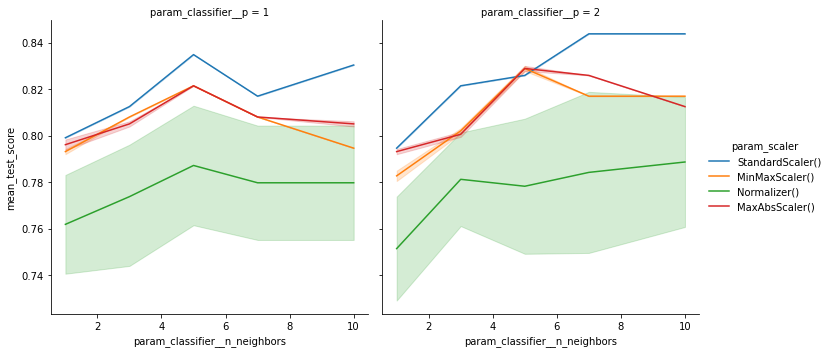

In [35]:
sns.relplot(data=results,
    kind='line',
    x='param_classifier__n_neighbors',
    y='mean_test_score',
    hue='param_scaler',
    col='param_classifier__p')
plt.show()

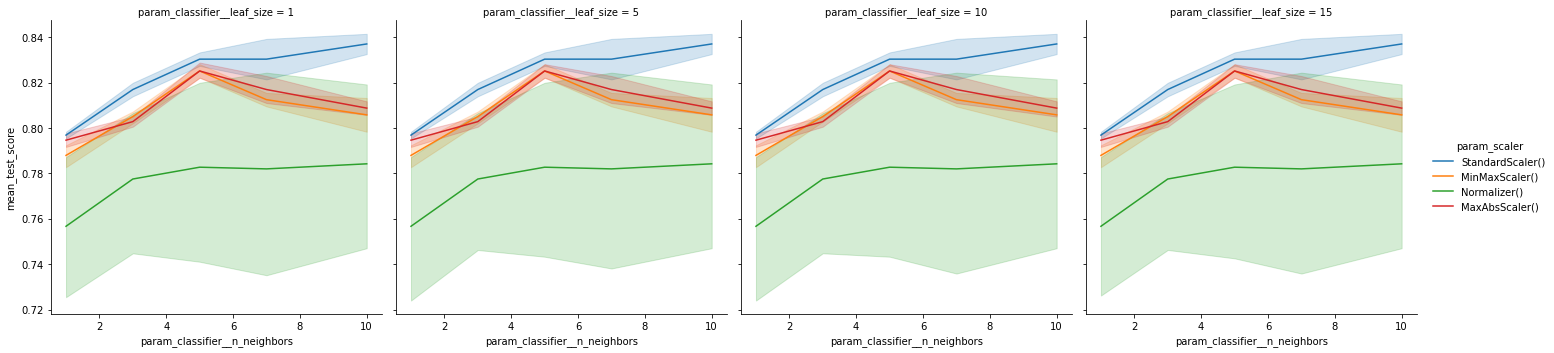

In [36]:
sns.relplot(data=results,
    kind='line',
    x='param_classifier__n_neighbors',
    y='mean_test_score',
    hue='param_scaler',
    col='param_classifier__leaf_size')
plt.show()